# Helpful Functions

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D


Using TensorFlow backend.


In [3]:
# Read MFCCs feature CSV file of audio of 100ms block

path="/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/training"
#filename=os.path.join(path,"100ms_7C.csv")
df=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/training/final_100ms.csv",na_values=['NA','?'])
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
#df=pd.read_csv(filename,na_values=['NA','?'])
filename_write = os.path.join(path,"/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/training/output_cnnkfold_100ms.csv")
print(df.shape)
df.head()

(2879855, 14)


,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-2.177482,28.989668,13.514783,3.274898,0.596447,0.398882,-0.708436,3.897990,-2.568868,4.084522,-3.458008,3.329399,0.502433,AC & FAN
1,-2.217528,29.009960,14.496528,3.937856,0.885757,0.382850,-3.029734,3.721529,-1.249983,5.907419,-4.396610,5.099895,-0.134206,AC & FAN
2,-2.157077,29.629701,14.559298,3.647526,0.612399,1.271464,-3.784228,2.127398,-2.638736,3.369799,-3.730211,5.022815,1.037247,AC & FAN
3,-2.078407,29.166139,15.066271,3.693529,1.686593,0.728231,-3.368825,3.075890,-2.924258,5.053575,-1.145492,3.734177,1.093625,AC & FAN
4,-2.085620,29.093788,13.834518,3.553311,0.222944,-0.190377,-2.344441,4.263392,-1.810713,5.807317,-2.152727,1.521383,0.662543,AC & FAN


In [4]:
print("Label has na? {}".format(pd.isnull(df['Label']).values.any()))

Label has na? False


In [5]:
df=df.dropna()
df.shape

(2879855, 14)

In [6]:
print("Label has na? {}".format(pd.isnull(df['Label']).values.any()))

Label has na? False


In [7]:
# Shuffle
np.random.seed(42)# set a seed so that the results are consistent
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-8.674390,-15.782101,-9.014501,-23.598510,-14.720270,-9.394463,8.632519,33.632657,-9.083369,-12.988056,-14.929171,-8.657153,1.998997,CRYING
1,-1.911238,-18.842382,-34.766056,3.829446,-24.594156,21.327238,7.549542,20.037894,-5.151323,-12.387786,-23.254159,9.522837,-17.909693,CRYING
2,0.281290,-14.679353,-29.949752,-5.299863,-45.347970,27.561231,6.183920,24.620650,-30.354956,-20.189063,0.107409,39.142069,7.633437,CRYING
3,-2.586621,-17.097926,6.881091,17.884864,-40.547504,-29.503349,-40.105238,12.979943,-24.573659,18.821428,21.814856,-11.700079,16.268420,SPEECH
4,-6.926440,9.224743,-2.142383,-1.558457,-26.140506,-17.126806,-13.105883,-7.250446,6.386086,-1.025086,-9.002003,-5.823928,-3.466868,SPEECH


In [8]:
# Encode to a 2D matrix for training
Label = encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(df,'Label')

Labelling is:['AC & FAN' 'CRYING' 'MUSIC' 'SPEECH']


/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.20)

In [10]:
print("Shape of x : {}".format(x.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of x : (2879855, 13)
Shape of y : (2879855, 4)
Shape of x_main : (2303884, 13)
Shape of x_holdout : (575971, 13)
Shape of y_main : (2303884, 4)
Shape of y_holdout : (575971, 4)


In [11]:
epochs=30
batch_size = 128
num_classes = 4
start_time = time.time()
# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))

for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    X_train = np.expand_dims(x_train, axis=2) # reshape (569, 30) to (569, 30, 1) 
    #y_train = np.expand_dims(y_train, axis=2)
    #y_test = np.expand_dims(y_test, axis=2)
    X_test = np.expand_dims(x_test, axis=2)
   

    model = Sequential()
    model.add(layers.Conv1D(50,2,activation='relu',input_shape=(13,1)))
    model.add(layers.Conv1D(50,2,activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(100,2,activation='relu'))
    model.add(layers.Conv1D(100,2,activation='relu'))
    model.add(layers.Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(y_train.shape[1],activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    monitor = [ EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=10,
                            verbose=0,
                            mode='auto'),ModelCheckpoint(filepath="best_weights_mycnn_100ms_mani.h5",
                                   verbose=0,
                                   save_best_only=True)] # save best model

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks= monitor,
                        verbose=0,
                        validation_data=(X_test, y_test))
   # model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    
   
    
    
    
    



    ####################
    pred = model.predict(X_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
    #######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)

print(model.summary())
    
    
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)

print("Final score (accuracy): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)



Fold #1
Fold score (accuracy): 0.9744171258548061
Elapsed time: 0:39:58.29
Confusion matrix, without normalization
[[115380      0     31      5]
 [     0 110985   2604   1894]
 [    27    703 111526   2509]
 [    20    994   3001 111098]]
Fold #2
Fold score (accuracy): 0.9747187902173937
Elapsed time: 1:19:52.52
Confusion matrix, without normalization
[[115074      1     72      7]
 [     0 112235   1928   1391]
 [    12   1146 110471   3415]
 [    10   1454   2213 111348]]
Fold #3
Fold score (accuracy): 0.9736249856221122
Elapsed time: 1:59:58.49
Confusion matrix, without normalization
[[114673      0     14      1]
 [     5 110808   2713   1681]
 [    43    765 111607   3151]
 [    25   1182   2573 111536]]
Fold #4
Fold score (accuracy): 0.9736228153748994
Elapsed time: 2:40:19.03
Confusion matrix, without normalization
[[115308      2     19      1]
 [     6 110468   2615   1641]
 [    35    788 111650   2751]
 [    18   1151   3127 111197]]
Fold #5
Fold score (accuracy): 0.9745125

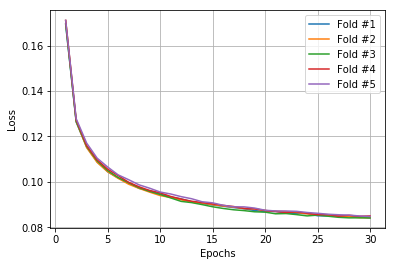

In [12]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("k-fold_loss_cnn_100ms_mani.eps")
plt.savefig("k-fold_loss_cnn_100ms_mani.png",dpi=150)
plt.show()

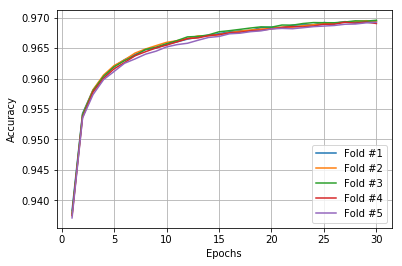

In [13]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("k-fold_acc_cnn_100ms_mani.eps",dpi=150)
plt.savefig('k-fold_acc_cnn_100ms_mani.png',dpi=150)
plt.show()

In [14]:
# Write the cross-validated prediction (from the last neural network)
import time
tic=time.time()
X_holdout = np.expand_dims(x_holdout, axis=2)
holdout_pred = model.predict(X_holdout)
toc=time.time()
print(str(1000*(toc-tic))+"ms")


31721.54450416565ms


In [15]:
holdout_pred1 = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare,holdout_pred1)
print("Holdout score (accuracy): {}".format(score))

Holdout score (accuracy): 0.9747261580878204


In [16]:
#X_holdout = np.expand_dims(x_holdout, axis=2)
#holdout_pred = model.predict(X_holdout)
score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.07007190694118855


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [18]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

Confusion matrix, without normalization
[[144098      3     27      6]
 [     1 139244   2114   2218]
 [    44   1602 137947   4743]
 [    12   1489   2298 140125]]


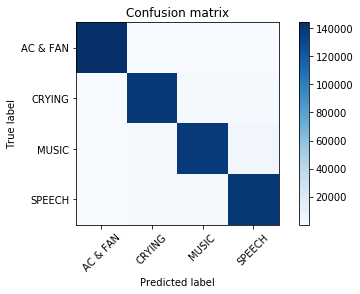

In [19]:

# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_cnn_100ms_mani.png',dpi=150)
plt.savefig('cm_cnn_100ms_mani.eps',dpi=150)



In [20]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_holdout_compare, holdout_pred1))  
print(classification_report(y_holdout_compare, holdout_pred1))

[[144098      3     27      6]
 [     1 139244   2114   2218]
 [    44   1602 137947   4743]
 [    12   1489   2298 140125]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    144134
           1       0.98      0.97      0.97    143577
           2       0.97      0.96      0.96    144336
           3       0.95      0.97      0.96    143924

   micro avg       0.97      0.97      0.97    575971
   macro avg       0.97      0.97      0.97    575971
weighted avg       0.97      0.97      0.97    575971



Confusion matrix, without normalization


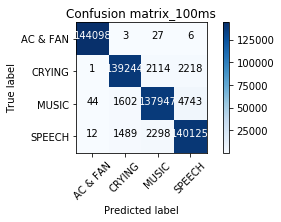

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout_compare, holdout_pred1)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['AC & FAN', 'CRYING','MUSIC', 'SPEECH'],
                      title='Confusion matrix_100ms')

plt.savefig('cnn_confusiponmatrix_100ms.png')

In [22]:
[[B1,C1,M1,N1],[B2,C2,M2,N2],[B3,C3,M3,N3],
 [B4,C4,M4,N4]]=cm

TP=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
TN=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
FP=np.sum(cm)-TP
FN=FP


Acc=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])/np.sum(cm)
print("Overall Accuracy: ",Acc*100)

Pr=(TP)/(TP+FP)
print("Precision: ",Pr*100)

Se=(TP)/(TP+FN)
print("Sensitivity/Recall: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=1-Acc
print("Error Rate: ",100*ER)

F_score = 2*TP /(2*TP + FP + FN)
print("F1-Score: ",F_score*100)

Overall Accuracy:  97.47261580878204
Precision:  97.47261580878204
Sensitivity/Recall:  97.47261580878204
Specificity:  97.47261580878204
Error Rate:  2.527384191217963
F1-Score:  97.47261580878204


In [23]:
tic=time.time()
model.save('my_CNN_100ms_mani.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

1298.9726066589355ms


In [6]:
from keras.models import load_model
import time
tic=time.time()
my_model=load_model('my_CNN_100ms_mani.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

1700.143575668335ms


In [7]:
df1=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/testing/fanactest_100ms.csv")
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df1.head()
df1.shape

(359981, 13)

In [8]:
df2 = np.expand_dims(df1, axis=2)# We have to add 1dimension more for testing
df2.shape

(359981, 13, 1)

In [9]:
tic=time.time()
my_his1=my_model.predict(df2)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

17531.02445602417ms


In [10]:
test_pred1 = np.argmax(my_his1, axis=1)
test_pred1[150:380]
print(test_pred1.shape)

(359981,)


In [15]:
c =0
for i in  test_pred1:
    if i== 0:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is AC & FAN")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is AC & FAN
Count is 238506


In [9]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of AC & FAN:',100*x)

Accuracy is for testing with new environment data of AC & FAN: 66.25516346696075


In [16]:
df3=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/testing/cryingtest_100ms.csv")
df3.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df3.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-11.532925,-41.439816,-10.013638,-5.886042,1.759984,5.037223,-7.673149,-9.511770,-16.812402,4.153761,10.477659,2.287526,-3.059897
1,-11.132136,-36.726535,-6.075866,-2.412740,3.656523,5.991037,-6.274219,-5.948665,-12.675685,3.190814,8.824465,1.740878,-4.977975
2,-10.583627,-40.753876,-7.334856,-3.710782,-0.050616,6.511381,-3.357559,-2.911659,-8.063696,2.940719,7.065572,2.832189,-4.986748
3,-10.230430,-42.837300,-9.278788,-3.923623,1.156336,8.304230,-2.481578,-2.876568,-7.910415,0.070745,2.850507,2.495628,-2.261219
4,-9.770289,-43.105286,-8.304959,-4.162195,2.176433,10.053204,-4.267742,-5.939098,-9.613048,1.381759,1.189527,2.285791,-3.813635


In [17]:
df4= np.expand_dims(df3, axis=2)# We have to add 1dimension more for testing
df4.shape

(359981, 13, 1)

In [18]:
tic=time.time()
my_his2=my_model.predict(df4)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

17945.713758468628ms


In [19]:
test_pred2 = np.argmax(my_his2, axis=1)
test_pred2[150:380]
print(test_pred2.shape)

(359981,)


In [23]:
c =0
for i in  test_pred2:
    if i== 1:
         c += 1
    else:
        continue 
if c > test_pred2.size/2:
    print("The tested audio is crying")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is crying
Count is 230654


In [15]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of crying:',100*x)

Accuracy is for testing with new environment data of crying: 64.07393723557632


In [24]:
df7=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/testing/musictest_100ms.csv")
df7.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df7.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-1.990123,-20.350678,-13.696701,3.631777,-31.725385,18.816110,-32.790862,2.403541,1.389364,-11.520431,18.829357,-2.981085,3.315220
1,-2.034620,-20.375766,-14.148921,3.194243,-31.738763,17.667094,-34.605984,2.908558,2.646545,-10.007036,19.021114,-1.875224,4.326378
2,-1.998620,-20.559211,-13.643551,4.088526,-31.637999,18.423230,-33.526329,3.590790,3.255856,-10.863344,18.494604,-1.581670,4.125259
3,-2.065147,-20.240945,-13.253146,5.043625,-30.390824,20.188941,-32.118361,4.604216,3.135303,-10.431314,15.644117,-2.382577,6.251958
4,-2.045668,-20.793000,-13.539983,4.327684,-31.059524,20.450706,-30.022440,6.100895,4.484121,-9.060196,17.732819,-2.039893,5.342894


In [25]:
df8 = np.expand_dims(df7, axis=2)# We have to add 1dimension more for testing
df8.shape

(359981, 13, 1)

In [26]:
tic=time.time()
my_his4=my_model.predict(df8)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

18289.352655410767ms


In [27]:
test_pred4 = np.argmax(my_his4, axis=1)
test_pred4[150:380]
print(test_pred4.shape)

(359981,)


In [31]:
c =0
for i in  test_pred4:
    if i== 2:
         c += 1
    else:
        continue 
if c > test_pred4.size/2:
    print("The tested audio is music")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is music
Count is 295565


In [21]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of music:',100*x)

Accuracy is for testing with new environment data of music: 82.10572224645189


In [33]:
df9=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/100ms/testing/speechtest_100ms.csv")
df9.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df9.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-0.050201,-1.459950,-47.080772,-7.018598,-11.433996,-20.761678,-12.831117,-0.354264,3.782690,-34.074036,-3.161392,-7.593636,-11.672030
1,-0.222368,-1.292799,-46.186094,-8.490439,-10.644840,-21.136131,-12.568691,0.842650,2.782625,-32.947479,-4.579298,-9.013817,-12.850303
2,-0.371657,0.892316,-42.921003,-3.493762,-5.445394,-14.351058,-4.787823,8.354385,10.320699,-26.221010,3.089642,-4.833432,-8.600031
3,-0.513524,-2.672771,-44.943169,-7.844133,-9.566689,-20.073346,-11.331026,1.852691,3.706034,-28.943520,-2.017533,-9.360505,-15.007542
4,-0.971738,-0.565293,-42.097997,-7.001646,-9.542562,-19.810856,-11.306753,1.330879,2.200913,-29.802182,0.201652,-10.412355,-14.063427


In [34]:
df10 = np.expand_dims(df9, axis=2)# We have to add 1dimension more for testing
df10.shape

(359981, 13, 1)

In [35]:
tic=time.time()
my_his5=my_model.predict(df10)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

17582.232236862183ms


In [36]:
test_pred5 = np.argmax(my_his5, axis=1)
test_pred5[150:380]
print(test_pred5.shape)

(359981,)


In [40]:
c =0
for i in  test_pred5:
    if i== 3:
         c += 1
    else:
        continue 
if c > test_pred5.size/2:
    print("The tested audio is speech")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is speech
Count is 334248


In [27]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of speech:',100*x)

Accuracy is for testing with new environment data of speech: 92.85156716604487
